In [ ]:
#cook, hrt, covid, ici, acc, acro
#PATH = '/content/drive/Shareddrives/systematic_review_research/data/qa_data/acro/balance_rule_neg.csv'
PATH = '/content/drive/Shareddrives/systematic_review_research/QA Combined Model'

!pip install transformers

#BERT imports
import torch
import os
from os.path import join
import tensorflow as tf
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, random_split
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup, BertModel, AutoTokenizer, AutoModel
from sklearn.metrics import classification_report, auc, roc_curve, precision_recall_curve
import torch.nn as nn
import pandas as pd
import io
import numpy as np
import time
import datetime
import matplotlib.pyplot as plt
% matplotlib inline

#Get the device name
device_name = tf.test.gpu_device_name()

# If there's a GPU available...if not, use CPU
if torch.cuda.is_available():       
    device = torch.device("cuda")
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

#Mount google drive
from google.colab import drive
drive.mount('/content/drive')

#Parse train input
df = pd.read_csv("/content/drive/Shareddrives/systematic_review_research/data/qa_data/{}/balance_rule_neg.csv".format(lbl))
df = df.replace({'label': {'Yes': 1, 'No': 0}})

#Create balanced dataset
includes = df.loc[df['label'] == 1]
excludes = df.loc[df['label'] == 0]

new_train = pd.DataFrame()
new_train = new_train.append([includes, excludes.sample(frac = 1)[0:len(includes)]])

#Parse balanced train dataset
train_sentences = new_train.text_segment.values
train_questions = new_train.question.values
train_labels = new_train.label.values

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

def tokenize_input(sentences, questions, labels):
  # Tokenize all of the sentences and map the tokens to thier word IDs.
  input_ids = []  
  attention_masks = []
  max_len = 0
  # For every sentence...
  for i in range(len(sentences)):
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    input = sentences[i] + ' [SEP] ' + questions[i]

    encoded_dict = tokenizer.encode_plus(
                    input,                      # Sentence to encode.
                    add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                    truncation = True, 
                    max_length = 256,           # Pad & truncate all sentences.
                    pad_to_max_length = True,
                    return_attention_mask = True,   # Construct attn. masks.
                    return_tensors = 'pt',     # Return pytorch tensors.
                )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
      
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

  # Convert the lists into tensors.
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)
  return input_ids, attention_masks, labels

#Tokenize train data
input_ids, attention_masks, labels = tokenize_input(train_sentences, train_questions, train_labels)

#Create a random 90-10 train-validation split.
dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), 
            batch_size = batch_size 
        )
validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset), 
            batch_size = batch_size
        )

#Class for Regression
class Classifier(nn.Module):

  def __init__(self, n_classes, model_path):
    super(Classifier, self).__init__()
    self.bert = AutoModel.from_pretrained(model_path)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
    logits= torch.nn.functional.softmax(self.out(output.pooler_output), dim=1)
    return logits

model = Classifier(2)

# Tell pytorch to run this model on the GPU.
model.cuda()
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, 
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

#Create number of training epochs, training steps, learning rate scheduler
epochs = 4
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

import random
import numpy as np


# Set the seed value all over the place to make this reproducible.
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# storing training quantities
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()
torch.cuda.empty_cache()

#Loss Function
cross_entropy= nn.CrossEntropyLoss().to(device)

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================  
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        torch.cuda.empty_cache()
        logits = model(b_input_ids, 
                             attention_mask=b_input_mask)
        torch.cuda.empty_cache()

        loss= cross_entropy(logits, b_labels)
        #Accumulate the training loss over all of the batches
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # measure performance on validation set

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            logits = model(b_input_ids, 
                                   attention_mask=b_input_mask)
        loss= cross_entropy(logits, b_labels)
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

if not os.path.exists(PATH):
  os.makedirs(PATH)

model_to_save = model.bert.module if hasattr(model.bert, 'module') else model.bert
model_to_save.save_pretrained(PATH)
        
torch.save(model.out.state_dict(), join(PATH, 'model_state.bin'))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading BERT tokenizer...


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


  561 training samples
   63 validation samples


Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will b


======== Epoch 1 / 4 ========
Training...

  Average training loss: 0.63
  Training epoch took: 0:00:24

Running Validation...
  Accuracy: 0.81
  Validation Loss: 0.57
  Validation took: 0:00:01

======== Epoch 2 / 4 ========
Training...

  Average training loss: 0.48
  Training epoch took: 0:00:25

Running Validation...
  Accuracy: 0.86
  Validation Loss: 0.48
  Validation took: 0:00:01

======== Epoch 3 / 4 ========
Training...

  Average training loss: 0.40
  Training epoch took: 0:00:26

Running Validation...
  Accuracy: 0.90
  Validation Loss: 0.43
  Validation took: 0:00:01

======== Epoch 4 / 4 ========
Training...

  Average training loss: 0.38
  Training epoch took: 0:00:26

Running Validation...
  Accuracy: 0.94
  Validation Loss: 0.41
  Validation took: 0:00:01

Training complete!
Total training took 0:01:45 (h:mm:ss)


In [ ]:
P99 = {}
P95 = {}
keyList2 = ['acc', 'ici', 'acro', 'cook', 'hrt', 'covid']
for i in keyList2:
  P99[i] = []
  P95[i] = []

In [ ]:
dict_report = {}

In [3]:
!pip install transformers

#BERT imports
import torch
import os
from os.path import join
import tensorflow as tf
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, random_split
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup, BertModel, AutoTokenizer, AutoModel
from sklearn.metrics import classification_report, auc, roc_curve, precision_recall_curve
import torch.nn as nn
import pandas as pd
import io
import numpy as np
import time
import datetime
import matplotlib.pyplot as plt
% matplotlib inline

#Mount google drive
from google.colab import drive
drive.mount('/content/drive')

#Get the device name
device_name = tf.test.gpu_device_name()

# If there's a GPU available...if not, use CPU
if torch.cuda.is_available():       
    device = torch.device("cuda")
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

lbl = 'covid'
model_path = '/content/drive/Shareddrives/systematic_review_research/QA Models/{}'.format(lbl)

class Classifier(nn.Module):

  def __init__(self, model_path, n_classes):
    super(Classifier, self).__init__()
    self.bert = AutoModel.from_pretrained(model_path)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
    logits= torch.nn.functional.softmax(self.out(output.pooler_output), dim=1)
    return logits

#Load Model
model= Classifier(model_path, 2)
weights_loss= torch.load(join(model_path, 'model_state.bin'))
model.out.load_state_dict(weights_loss)
model.to(device)


#Parse test input
df_test = pd.read_csv("/content/drive/Shareddrives/systematic_review_research/data/raw_data/test/{}.csv".format(lbl))
df_test = df_test.replace({'label': {'Include': 1, 'Exclude': 0}})
test_sentences = df_test.text_segment.values
test_labels = df_test.label.values

tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

def tokenize_input(sentences, labels):
  # Tokenize all of the sentences and map the tokens to thier word IDs.
  input_ids = []  
  attention_masks = []
  max_len = 0
  # For every sentence...
  for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.

    encoded_dict = tokenizer.encode_plus(
                    sent,                      # Sentence to encode.
                    add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                    truncation = True, 
                    max_length = 256,           # Pad & truncate all sentences.
                    pad_to_max_length = True,
                    return_attention_mask = True,   # Construct attn. masks.
                    return_tensors = 'pt',     # Return pytorch tensors.
                )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
      
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

  # Convert the lists into tensors.
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)
  return input_ids, attention_masks, labels


#Tokenize test input
test_input_ids, test_attention_masks, test_labels = tokenize_input(test_sentences, test_labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(test_input_ids, test_attention_masks, test_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(test_input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels, pred_true = [], [], []

def plot_pr_curve(y_true, y_scores):
    print("Ploting P-R curve ...")
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    return precision, recall, thresholds

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, attention_mask=b_input_mask)


  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  for i in logits:
    pred_true.append(i[1])
  true_labels.append(label_ids.tolist())

print('    DONE.')

pred_labels = []
for i in range(len(true_labels)):
  # Pick the label with the highest value and turn this in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  pred_labels.append(pred_labels_i)

#flatten into 1d array
pred_labels = np.hstack(pred_labels)
true_labels = np.hstack(true_labels)
pred_true = np.hstack(pred_true)

#extract metrics
report= classification_report(true_labels, pred_labels, output_dict=True)
precision, recall, thresholds = plot_pr_curve(true_labels, pred_true)
print(report)
#print(thresholds)
#plt.plot(precision, recall)
#plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Predicting labels for 748 test sentences...
    DONE.
Ploting P-R curve ...
{'0': {'precision': 0.9320557491289199, 'recall': 0.8118361153262519, 'f1-score': 0.8678021086780211, 'support': 659}, '1': {'precision': 0.28735632183908044, 'recall': 0.5617977528089888, 'f1-score': 0.38022813688212925, 'support': 89}, 'accuracy': 0.7820855614973262, 'macro avg': {'precision': 0.6097060354840002, 'recall': 0.6868169340676203, 'f1-score': 0.6240151227800752, 'support': 748}, 'weighted avg': {'precision': 0.8553468600529898, 'recall': 0.7820855614973262, 'f1-score': 0.8097886280766383, 'support': 748}}


{'acc': [0.6595744680851063, 0.6595744680851063], 'ici': [0.8235294117647058], 'acro': [0.21935483870967742], 'cook': [0.15028901734104047], 'hrt': [0.34810126582278483], 'covid': [0.16346153846153846]}
{'acc': [0.39759036144578314, 0.39759036144578314], 'ici': [0.6385737439222042], 'acro': [0.22641509433962265], 'cook': [0.15428571428571428], 'hrt': [0.1945392491467577], 'covid': [0.12680115273775217]}


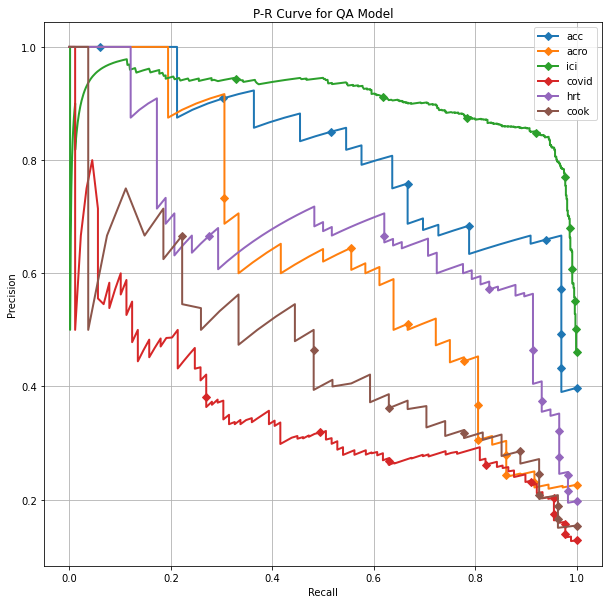

In [ ]:
import matplotlib.ticker as mtick
import math
import numpy as np

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

lst = np.linspace(0, 1, 11)

dict_report["{}".format(lbl)] = {"precision": precision, "recall": recall}
p99 = find_nearest(dict_report["{}".format(lbl)]["recall"], 0.99)
p95 = find_nearest(dict_report["{}".format(lbl)]["recall"], 0.95)
P99["{}".format(lbl)].append(dict_report["{}".format(lbl)]["precision"][p99])
P95["{}".format(lbl)].append(dict_report["{}".format(lbl)]["precision"][p95])
print(P95)
print(P99)

fig, ax = plt.subplots(figsize = (10, 10))
for key in dict_report:
  markers_on = math.ceil(len(dict_report["{}".format(key)]["precision"])/10)
  plt.plot(dict_report["{}".format(key)]["recall"], dict_report["{}".format(key)]["precision"], '-D', markevery = markers_on, linewidth = 2, label = "{}".format(key))
plt.title('P-R Curve for QA Model')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid()
plt.show()

{'ici': [0.6385737439222042], 'acro': [0.22641509433962265], 'cook': [0.15428571428571428], 'hrt': [0.1945392491467577], 'covid': [0.12680115273775217], 'acc': 0.39759036144578314}
{'ici': [0.8235294117647058], 'acro': [0.21935483870967742], 'cook': [0.15028901734104047], 'hrt': [0.34810126582278483], 'covid': [0.16346153846153846], 'acc': 0.6595744680851063}


ValueError: ignored

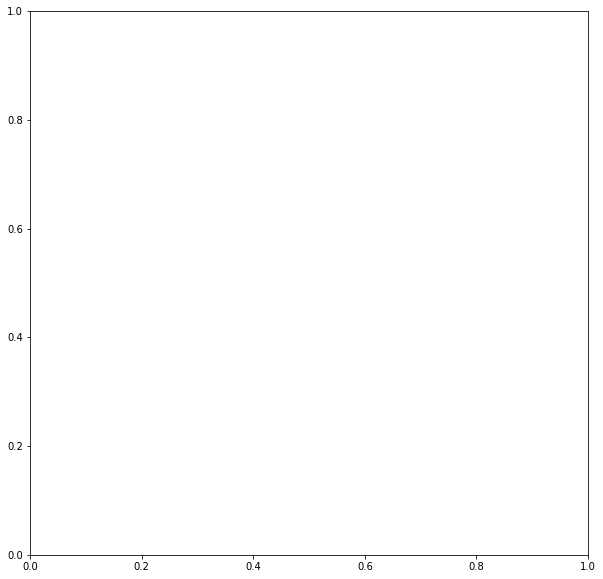

In [ ]:
from matplotlib import style

print(P99)
print(P95)
x_axis = [10, 50, 100, 200]
fig, ax = plt.subplots(figsize = (10, 10))
for key in P99:
  plt.plot(x_axis, P95["{}".format(key)], '-s', markersize = 5, label = "{}".format(key))
  #plt.errorbar(x_axis, P99["{}".format(key)], err = 0.9)
plt.title('P@0.95')
plt.xlabel('Number of Training Samples')
plt.ylabel('Precision at High Recall')
plt.xticks([10, 50, 100, 200])
plt.legend()
plt.grid()
plt.show()

In [ ]:
P99['acc'] = 0.39759036144578314
P95['acc'] = 0.6595744680851063
print(P99)

{'ici': [0.6385737439222042], 'acro': [0.22641509433962265], 'cook': [0.15428571428571428], 'hrt': [0.1945392491467577], 'covid': [0.12680115273775217], 'acc': 0.39759036144578314}
